# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

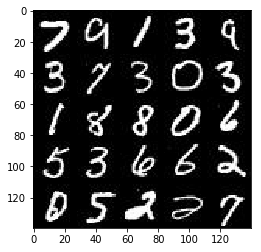

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

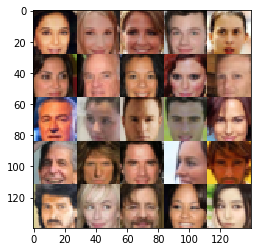

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.7)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=1, padding="same",
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, 0.7)
        # 14x14x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding="same",
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, 0.7)
        # 7x7x256
        
        x4 = tf.layers.conv2d(x3, 512, 5, strides=1, padding="same",
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha*x4, x4)
        x4 = tf.nn.dropout(x4, 0.7)
        # 7x7x512
        
        # Flatten
        flat = tf.reshape(x4, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*1024)
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.8)
        # 7x7x1024
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.8)
        # 7x7x512 now
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.8)
        # 14x14x256 now
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, 0.8)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
    
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, input_lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Resize images ( -1 to 1)
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                
                if steps % 10 == 0 or steps == 1:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0 or steps == 1:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
        show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
        print("Done");
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.2224... Generator Loss: 0.2778


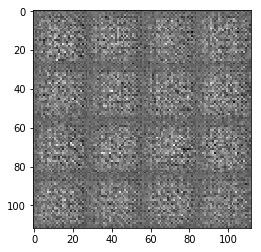

Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 0.9101
Epoch 1/2... Discriminator Loss: 5.5569... Generator Loss: 0.0160
Epoch 1/2... Discriminator Loss: 1.4278... Generator Loss: 3.8287
Epoch 1/2... Discriminator Loss: 2.6373... Generator Loss: 4.3695
Epoch 1/2... Discriminator Loss: 1.0476... Generator Loss: 2.8159
Epoch 1/2... Discriminator Loss: 0.9285... Generator Loss: 1.7430
Epoch 1/2... Discriminator Loss: 5.2686... Generator Loss: 6.7850
Epoch 1/2... Discriminator Loss: 1.8597... Generator Loss: 1.3262
Epoch 1/2... Discriminator Loss: 1.2227... Generator Loss: 1.5393
Epoch 1/2... Discriminator Loss: 1.2291... Generator Loss: 1.0768


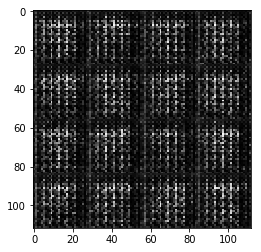

Epoch 1/2... Discriminator Loss: 1.4368... Generator Loss: 1.5523
Epoch 1/2... Discriminator Loss: 0.5769... Generator Loss: 3.9496
Epoch 1/2... Discriminator Loss: 2.1145... Generator Loss: 0.8389
Epoch 1/2... Discriminator Loss: 1.8507... Generator Loss: 2.2372
Epoch 1/2... Discriminator Loss: 0.8667... Generator Loss: 2.4875
Epoch 1/2... Discriminator Loss: 0.8502... Generator Loss: 2.1435
Epoch 1/2... Discriminator Loss: 1.6909... Generator Loss: 3.4453
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 2.4649
Epoch 1/2... Discriminator Loss: 1.1084... Generator Loss: 1.2891
Epoch 1/2... Discriminator Loss: 1.7533... Generator Loss: 0.9340


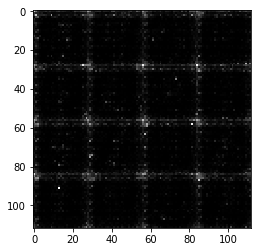

Epoch 1/2... Discriminator Loss: 2.1083... Generator Loss: 1.2951
Epoch 1/2... Discriminator Loss: 1.7355... Generator Loss: 2.0818
Epoch 1/2... Discriminator Loss: 1.7755... Generator Loss: 0.9409
Epoch 1/2... Discriminator Loss: 1.2458... Generator Loss: 1.7613
Epoch 1/2... Discriminator Loss: 1.1393... Generator Loss: 1.8393
Epoch 1/2... Discriminator Loss: 0.8834... Generator Loss: 2.5946
Epoch 1/2... Discriminator Loss: 1.1214... Generator Loss: 1.4855
Epoch 1/2... Discriminator Loss: 1.2054... Generator Loss: 1.3170
Epoch 1/2... Discriminator Loss: 1.5185... Generator Loss: 1.8554
Epoch 1/2... Discriminator Loss: 1.4594... Generator Loss: 1.8969


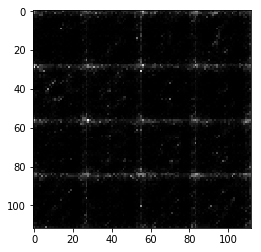

Epoch 1/2... Discriminator Loss: 1.5179... Generator Loss: 1.3608
Epoch 1/2... Discriminator Loss: 1.6521... Generator Loss: 0.9661
Epoch 1/2... Discriminator Loss: 1.0807... Generator Loss: 1.4330
Epoch 1/2... Discriminator Loss: 1.2855... Generator Loss: 1.7859
Epoch 1/2... Discriminator Loss: 1.3591... Generator Loss: 0.8544
Epoch 1/2... Discriminator Loss: 1.8213... Generator Loss: 0.6420
Epoch 1/2... Discriminator Loss: 1.2583... Generator Loss: 0.9870
Epoch 1/2... Discriminator Loss: 1.3584... Generator Loss: 2.1112
Epoch 1/2... Discriminator Loss: 1.7696... Generator Loss: 2.0862
Epoch 1/2... Discriminator Loss: 1.3421... Generator Loss: 1.1850


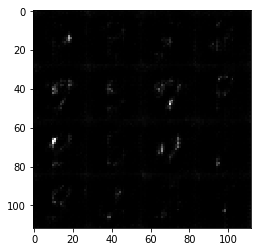

Epoch 1/2... Discriminator Loss: 1.2857... Generator Loss: 1.9932
Epoch 1/2... Discriminator Loss: 1.3795... Generator Loss: 0.6697
Epoch 1/2... Discriminator Loss: 1.3001... Generator Loss: 0.8022
Epoch 1/2... Discriminator Loss: 1.0931... Generator Loss: 1.5057
Epoch 1/2... Discriminator Loss: 1.3087... Generator Loss: 1.2132
Epoch 1/2... Discriminator Loss: 1.3241... Generator Loss: 1.4732
Epoch 1/2... Discriminator Loss: 1.6521... Generator Loss: 0.9193
Epoch 1/2... Discriminator Loss: 1.6196... Generator Loss: 0.4694
Epoch 1/2... Discriminator Loss: 1.4742... Generator Loss: 0.6900
Epoch 1/2... Discriminator Loss: 1.2872... Generator Loss: 0.9520


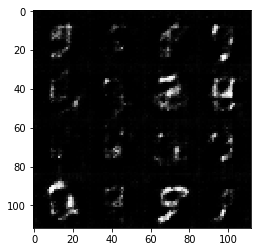

Epoch 1/2... Discriminator Loss: 1.4170... Generator Loss: 1.2094
Epoch 1/2... Discriminator Loss: 1.1902... Generator Loss: 1.6107
Epoch 1/2... Discriminator Loss: 1.4307... Generator Loss: 1.7508
Epoch 1/2... Discriminator Loss: 1.4348... Generator Loss: 1.3957
Epoch 1/2... Discriminator Loss: 1.8394... Generator Loss: 2.1476
Epoch 1/2... Discriminator Loss: 1.3327... Generator Loss: 1.3729
Epoch 1/2... Discriminator Loss: 1.6954... Generator Loss: 2.0487
Epoch 1/2... Discriminator Loss: 1.3271... Generator Loss: 0.6282
Epoch 1/2... Discriminator Loss: 1.5868... Generator Loss: 1.3353
Epoch 1/2... Discriminator Loss: 1.3529... Generator Loss: 0.9805


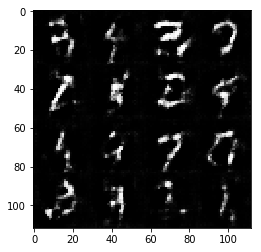

Epoch 1/2... Discriminator Loss: 1.2750... Generator Loss: 0.7636
Epoch 1/2... Discriminator Loss: 1.7732... Generator Loss: 1.0769
Epoch 1/2... Discriminator Loss: 1.2611... Generator Loss: 1.0071
Epoch 1/2... Discriminator Loss: 1.3145... Generator Loss: 0.8405
Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 0.6612
Epoch 1/2... Discriminator Loss: 1.1283... Generator Loss: 1.4099
Epoch 1/2... Discriminator Loss: 1.2616... Generator Loss: 1.2543
Epoch 1/2... Discriminator Loss: 1.4224... Generator Loss: 1.2816
Epoch 1/2... Discriminator Loss: 1.2894... Generator Loss: 1.2359
Epoch 1/2... Discriminator Loss: 1.5494... Generator Loss: 0.8665


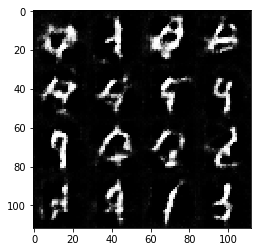

Epoch 1/2... Discriminator Loss: 1.4528... Generator Loss: 0.9812
Epoch 1/2... Discriminator Loss: 1.2952... Generator Loss: 0.9940
Epoch 1/2... Discriminator Loss: 1.5635... Generator Loss: 2.0593
Epoch 1/2... Discriminator Loss: 1.2961... Generator Loss: 0.9880
Epoch 1/2... Discriminator Loss: 1.4291... Generator Loss: 0.6218
Epoch 1/2... Discriminator Loss: 1.1322... Generator Loss: 1.0249
Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 1.7658
Epoch 1/2... Discriminator Loss: 1.3045... Generator Loss: 1.2216
Epoch 1/2... Discriminator Loss: 1.4099... Generator Loss: 0.7546
Epoch 1/2... Discriminator Loss: 2.0094... Generator Loss: 2.0798


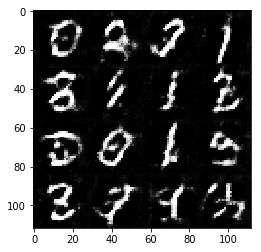

Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 0.8885
Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 0.9715
Epoch 1/2... Discriminator Loss: 1.4269... Generator Loss: 0.7470
Epoch 1/2... Discriminator Loss: 1.3462... Generator Loss: 1.0956
Epoch 1/2... Discriminator Loss: 1.4494... Generator Loss: 0.8048
Epoch 1/2... Discriminator Loss: 1.6195... Generator Loss: 0.5918
Epoch 1/2... Discriminator Loss: 1.5837... Generator Loss: 0.4660
Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 0.7657
Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 0.8193
Epoch 1/2... Discriminator Loss: 1.2036... Generator Loss: 0.9534


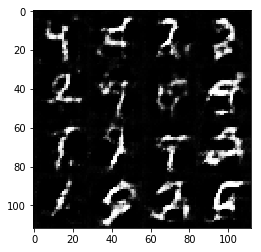

Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 1.0566
Epoch 1/2... Discriminator Loss: 1.1696... Generator Loss: 1.0554
Epoch 1/2... Discriminator Loss: 1.6016... Generator Loss: 2.0178
Epoch 1/2... Discriminator Loss: 1.0904... Generator Loss: 0.8553
Epoch 1/2... Discriminator Loss: 1.5460... Generator Loss: 0.6682
Epoch 1/2... Discriminator Loss: 1.2586... Generator Loss: 0.9014
Epoch 1/2... Discriminator Loss: 1.2235... Generator Loss: 0.8271
Epoch 1/2... Discriminator Loss: 1.3409... Generator Loss: 1.1813
Epoch 1/2... Discriminator Loss: 1.4819... Generator Loss: 1.0370
Epoch 1/2... Discriminator Loss: 1.6389... Generator Loss: 0.4921


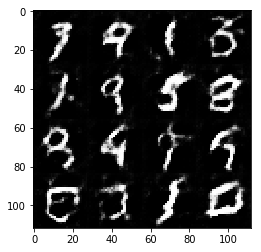

Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 1.7952
Epoch 1/2... Discriminator Loss: 1.4454... Generator Loss: 1.4138
Epoch 1/2... Discriminator Loss: 1.4682... Generator Loss: 0.7470
Epoch 1/2... Discriminator Loss: 1.1956... Generator Loss: 0.6942
Epoch 1/2... Discriminator Loss: 1.4063... Generator Loss: 0.8310
Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 1.1483
Epoch 1/2... Discriminator Loss: 1.3928... Generator Loss: 0.6934
Epoch 1/2... Discriminator Loss: 1.5890... Generator Loss: 1.1174
Epoch 1/2... Discriminator Loss: 1.2928... Generator Loss: 1.1354
Epoch 1/2... Discriminator Loss: 1.4783... Generator Loss: 1.2971


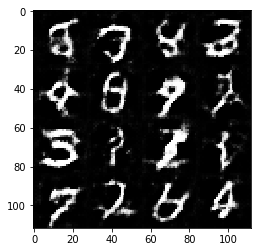

Epoch 1/2... Discriminator Loss: 1.2039... Generator Loss: 0.8641
Epoch 1/2... Discriminator Loss: 1.2039... Generator Loss: 0.7231
Epoch 1/2... Discriminator Loss: 1.3689... Generator Loss: 0.5885
Epoch 1/2... Discriminator Loss: 1.2730... Generator Loss: 1.6704
Epoch 1/2... Discriminator Loss: 1.5033... Generator Loss: 1.7876
Epoch 1/2... Discriminator Loss: 1.4692... Generator Loss: 0.9676
Epoch 1/2... Discriminator Loss: 1.3009... Generator Loss: 0.9784
Epoch 1/2... Discriminator Loss: 1.2756... Generator Loss: 0.8791
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.9365
Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 1.4524


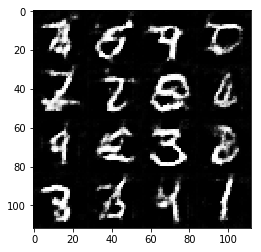

Epoch 1/2... Discriminator Loss: 1.3689... Generator Loss: 1.4969
Epoch 1/2... Discriminator Loss: 1.4609... Generator Loss: 0.6106
Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 1.7110
Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 1.4192
Epoch 1/2... Discriminator Loss: 1.4401... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.2857... Generator Loss: 0.7085
Epoch 1/2... Discriminator Loss: 1.3064... Generator Loss: 1.0805
Epoch 1/2... Discriminator Loss: 1.3408... Generator Loss: 1.6833
Epoch 1/2... Discriminator Loss: 1.6430... Generator Loss: 0.5438
Epoch 1/2... Discriminator Loss: 1.5891... Generator Loss: 2.4262


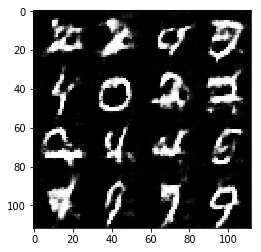

Epoch 1/2... Discriminator Loss: 1.6251... Generator Loss: 0.4844
Epoch 1/2... Discriminator Loss: 1.2924... Generator Loss: 0.9065
Epoch 1/2... Discriminator Loss: 1.4678... Generator Loss: 0.5338
Epoch 1/2... Discriminator Loss: 1.2478... Generator Loss: 0.9537
Epoch 1/2... Discriminator Loss: 1.4329... Generator Loss: 0.6496
Epoch 1/2... Discriminator Loss: 1.5112... Generator Loss: 0.8307
Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 1.8321
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 1.9199
Epoch 1/2... Discriminator Loss: 1.3485... Generator Loss: 0.9820
Epoch 1/2... Discriminator Loss: 1.2767... Generator Loss: 1.1675


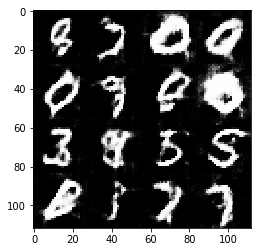

Epoch 1/2... Discriminator Loss: 1.3661... Generator Loss: 1.7509
Epoch 1/2... Discriminator Loss: 1.1840... Generator Loss: 1.0553
Epoch 1/2... Discriminator Loss: 1.1263... Generator Loss: 1.0612
Epoch 1/2... Discriminator Loss: 1.4167... Generator Loss: 1.0305
Epoch 1/2... Discriminator Loss: 1.1430... Generator Loss: 0.7894
Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 1.1752
Epoch 1/2... Discriminator Loss: 1.5774... Generator Loss: 2.3838
Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 1.4241... Generator Loss: 1.8216
Epoch 1/2... Discriminator Loss: 1.2754... Generator Loss: 1.0201


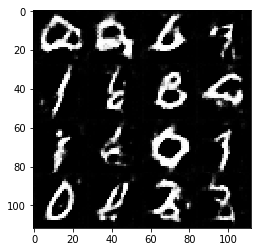

Epoch 1/2... Discriminator Loss: 1.2729... Generator Loss: 1.4897
Epoch 1/2... Discriminator Loss: 1.1686... Generator Loss: 1.2944
Epoch 1/2... Discriminator Loss: 1.3783... Generator Loss: 0.9122
Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 2.3744
Epoch 1/2... Discriminator Loss: 1.1143... Generator Loss: 1.1961
Epoch 1/2... Discriminator Loss: 1.6762... Generator Loss: 2.1975
Epoch 1/2... Discriminator Loss: 1.0602... Generator Loss: 0.7684
Epoch 1/2... Discriminator Loss: 1.3416... Generator Loss: 1.1733
Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 0.9880
Epoch 1/2... Discriminator Loss: 1.1514... Generator Loss: 1.4125


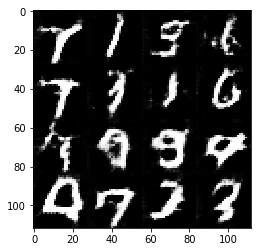

Epoch 1/2... Discriminator Loss: 1.4208... Generator Loss: 0.6724
Epoch 1/2... Discriminator Loss: 1.1343... Generator Loss: 1.2614
Epoch 1/2... Discriminator Loss: 1.2900... Generator Loss: 0.7461
Epoch 1/2... Discriminator Loss: 1.2135... Generator Loss: 1.0213
Epoch 1/2... Discriminator Loss: 1.1485... Generator Loss: 0.9449
Epoch 1/2... Discriminator Loss: 1.6432... Generator Loss: 0.4292
Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 0.9293
Epoch 1/2... Discriminator Loss: 1.1828... Generator Loss: 1.4484
Epoch 1/2... Discriminator Loss: 1.3176... Generator Loss: 1.0878
Epoch 1/2... Discriminator Loss: 1.2721... Generator Loss: 0.7083


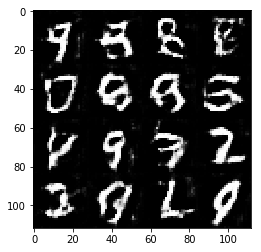

Epoch 1/2... Discriminator Loss: 1.6256... Generator Loss: 1.8916
Epoch 1/2... Discriminator Loss: 1.1013... Generator Loss: 1.3574
Epoch 1/2... Discriminator Loss: 1.2850... Generator Loss: 0.8611
Epoch 1/2... Discriminator Loss: 1.0557... Generator Loss: 1.0731
Epoch 1/2... Discriminator Loss: 1.6414... Generator Loss: 0.4968
Epoch 1/2... Discriminator Loss: 1.4711... Generator Loss: 0.4640
Epoch 1/2... Discriminator Loss: 1.0851... Generator Loss: 1.0009
Epoch 1/2... Discriminator Loss: 1.0336... Generator Loss: 1.1080
Epoch 1/2... Discriminator Loss: 0.9996... Generator Loss: 1.6329
Epoch 1/2... Discriminator Loss: 1.5822... Generator Loss: 2.3750


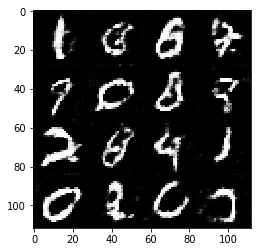

Epoch 1/2... Discriminator Loss: 1.5069... Generator Loss: 2.1620
Epoch 1/2... Discriminator Loss: 1.3419... Generator Loss: 0.9319
Epoch 1/2... Discriminator Loss: 1.0503... Generator Loss: 1.5645
Epoch 1/2... Discriminator Loss: 1.2870... Generator Loss: 1.0742
Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 0.6795
Epoch 1/2... Discriminator Loss: 1.2603... Generator Loss: 0.6855
Epoch 1/2... Discriminator Loss: 1.4575... Generator Loss: 2.6138
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 1.0781
Epoch 2/2... Discriminator Loss: 1.1673... Generator Loss: 1.5504
Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 1.4856


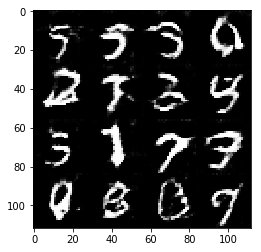

Epoch 2/2... Discriminator Loss: 1.1528... Generator Loss: 1.1625
Epoch 2/2... Discriminator Loss: 0.7552... Generator Loss: 1.3165
Epoch 2/2... Discriminator Loss: 1.0120... Generator Loss: 2.1424
Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 2.1286
Epoch 2/2... Discriminator Loss: 1.2586... Generator Loss: 1.6327
Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.9077
Epoch 2/2... Discriminator Loss: 1.1036... Generator Loss: 1.3610
Epoch 2/2... Discriminator Loss: 1.3166... Generator Loss: 1.2355
Epoch 2/2... Discriminator Loss: 1.3728... Generator Loss: 0.6257
Epoch 2/2... Discriminator Loss: 1.3044... Generator Loss: 1.2462


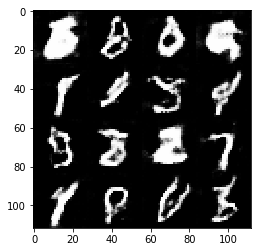

Epoch 2/2... Discriminator Loss: 1.3026... Generator Loss: 1.0433
Epoch 2/2... Discriminator Loss: 1.6460... Generator Loss: 2.4905
Epoch 2/2... Discriminator Loss: 0.9695... Generator Loss: 1.8315
Epoch 2/2... Discriminator Loss: 1.4466... Generator Loss: 3.1358
Epoch 2/2... Discriminator Loss: 1.3253... Generator Loss: 0.5940
Epoch 2/2... Discriminator Loss: 1.1270... Generator Loss: 0.9949
Epoch 2/2... Discriminator Loss: 1.2837... Generator Loss: 1.1577
Epoch 2/2... Discriminator Loss: 1.2064... Generator Loss: 0.6236
Epoch 2/2... Discriminator Loss: 1.0552... Generator Loss: 1.2814
Epoch 2/2... Discriminator Loss: 1.1331... Generator Loss: 1.0622


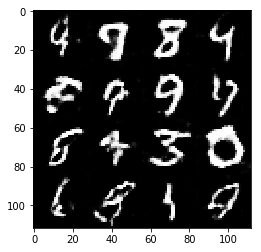

Epoch 2/2... Discriminator Loss: 0.9222... Generator Loss: 1.6265
Epoch 2/2... Discriminator Loss: 1.6583... Generator Loss: 0.6358
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 1.4632
Epoch 2/2... Discriminator Loss: 1.4714... Generator Loss: 0.8518
Epoch 2/2... Discriminator Loss: 1.1432... Generator Loss: 1.0030
Epoch 2/2... Discriminator Loss: 1.0778... Generator Loss: 1.1549
Epoch 2/2... Discriminator Loss: 1.2618... Generator Loss: 2.0110
Epoch 2/2... Discriminator Loss: 1.1465... Generator Loss: 2.1522
Epoch 2/2... Discriminator Loss: 1.1938... Generator Loss: 2.1156
Epoch 2/2... Discriminator Loss: 0.9128... Generator Loss: 1.3839


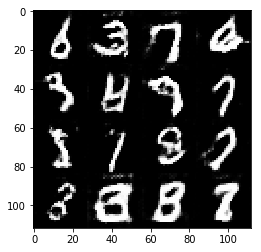

Epoch 2/2... Discriminator Loss: 1.0713... Generator Loss: 1.9694
Epoch 2/2... Discriminator Loss: 0.8774... Generator Loss: 1.2241
Epoch 2/2... Discriminator Loss: 1.1852... Generator Loss: 1.6337
Epoch 2/2... Discriminator Loss: 0.9988... Generator Loss: 1.7100
Epoch 2/2... Discriminator Loss: 1.0746... Generator Loss: 1.0649
Epoch 2/2... Discriminator Loss: 1.0239... Generator Loss: 1.7281
Epoch 2/2... Discriminator Loss: 1.1083... Generator Loss: 0.8638
Epoch 2/2... Discriminator Loss: 1.7313... Generator Loss: 3.4606
Epoch 2/2... Discriminator Loss: 0.8675... Generator Loss: 1.3067
Epoch 2/2... Discriminator Loss: 1.4146... Generator Loss: 0.5693


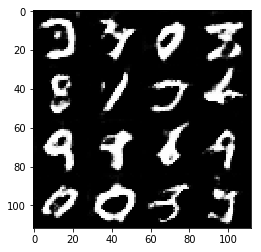

Epoch 2/2... Discriminator Loss: 1.0055... Generator Loss: 2.2524
Epoch 2/2... Discriminator Loss: 1.1125... Generator Loss: 0.8644
Epoch 2/2... Discriminator Loss: 1.3290... Generator Loss: 1.6544
Epoch 2/2... Discriminator Loss: 0.9610... Generator Loss: 1.3163
Epoch 2/2... Discriminator Loss: 1.1589... Generator Loss: 1.0228
Epoch 2/2... Discriminator Loss: 1.4040... Generator Loss: 1.0199
Epoch 2/2... Discriminator Loss: 1.0941... Generator Loss: 2.0348
Epoch 2/2... Discriminator Loss: 0.9055... Generator Loss: 1.7034
Epoch 2/2... Discriminator Loss: 1.2123... Generator Loss: 0.9487
Epoch 2/2... Discriminator Loss: 1.0843... Generator Loss: 1.4964


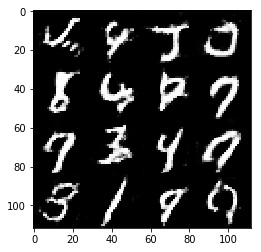

Epoch 2/2... Discriminator Loss: 0.9951... Generator Loss: 0.8797
Epoch 2/2... Discriminator Loss: 1.1669... Generator Loss: 1.7080
Epoch 2/2... Discriminator Loss: 1.1237... Generator Loss: 1.1025
Epoch 2/2... Discriminator Loss: 0.9965... Generator Loss: 1.2294
Epoch 2/2... Discriminator Loss: 0.8976... Generator Loss: 1.5448
Epoch 2/2... Discriminator Loss: 1.6555... Generator Loss: 0.4081
Epoch 2/2... Discriminator Loss: 0.7009... Generator Loss: 1.7380
Epoch 2/2... Discriminator Loss: 0.8880... Generator Loss: 2.5245
Epoch 2/2... Discriminator Loss: 1.0644... Generator Loss: 1.0778
Epoch 2/2... Discriminator Loss: 1.1374... Generator Loss: 0.9998


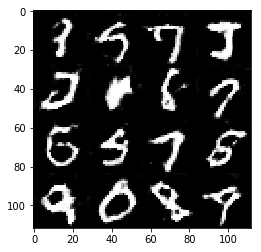

Epoch 2/2... Discriminator Loss: 1.5239... Generator Loss: 2.6434
Epoch 2/2... Discriminator Loss: 1.0283... Generator Loss: 1.1332
Epoch 2/2... Discriminator Loss: 1.1446... Generator Loss: 1.0038
Epoch 2/2... Discriminator Loss: 0.9570... Generator Loss: 0.8665
Epoch 2/2... Discriminator Loss: 1.3290... Generator Loss: 1.1012
Epoch 2/2... Discriminator Loss: 0.9050... Generator Loss: 1.4920
Epoch 2/2... Discriminator Loss: 0.6225... Generator Loss: 1.8343
Epoch 2/2... Discriminator Loss: 0.8949... Generator Loss: 1.0886
Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 2.1585
Epoch 2/2... Discriminator Loss: 1.3349... Generator Loss: 0.9997


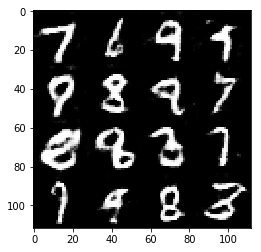

Epoch 2/2... Discriminator Loss: 1.0518... Generator Loss: 1.2446
Epoch 2/2... Discriminator Loss: 0.9552... Generator Loss: 1.6294
Epoch 2/2... Discriminator Loss: 1.1467... Generator Loss: 1.9945
Epoch 2/2... Discriminator Loss: 0.9967... Generator Loss: 1.2014
Epoch 2/2... Discriminator Loss: 2.6235... Generator Loss: 3.5535
Epoch 2/2... Discriminator Loss: 1.0061... Generator Loss: 1.1059
Epoch 2/2... Discriminator Loss: 1.3051... Generator Loss: 0.7270
Epoch 2/2... Discriminator Loss: 0.9007... Generator Loss: 1.6423
Epoch 2/2... Discriminator Loss: 0.8560... Generator Loss: 1.6975
Epoch 2/2... Discriminator Loss: 0.6921... Generator Loss: 1.8721


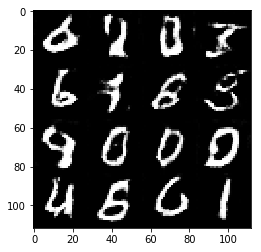

Epoch 2/2... Discriminator Loss: 0.7859... Generator Loss: 1.1865
Epoch 2/2... Discriminator Loss: 0.8505... Generator Loss: 2.5942
Epoch 2/2... Discriminator Loss: 0.9460... Generator Loss: 1.3216
Epoch 2/2... Discriminator Loss: 1.1980... Generator Loss: 0.3806
Epoch 2/2... Discriminator Loss: 1.0669... Generator Loss: 1.8898
Epoch 2/2... Discriminator Loss: 0.8268... Generator Loss: 1.5215
Epoch 2/2... Discriminator Loss: 1.0820... Generator Loss: 3.1537
Epoch 2/2... Discriminator Loss: 0.8526... Generator Loss: 1.2436
Epoch 2/2... Discriminator Loss: 0.8044... Generator Loss: 2.1108
Epoch 2/2... Discriminator Loss: 0.8619... Generator Loss: 1.5948


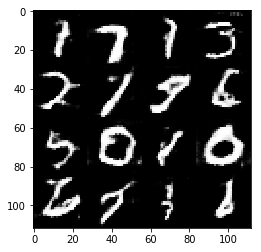

Epoch 2/2... Discriminator Loss: 1.0685... Generator Loss: 2.8228
Epoch 2/2... Discriminator Loss: 0.8734... Generator Loss: 3.1650
Epoch 2/2... Discriminator Loss: 1.3408... Generator Loss: 0.5135
Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 1.1382
Epoch 2/2... Discriminator Loss: 0.7149... Generator Loss: 1.4833
Epoch 2/2... Discriminator Loss: 1.0506... Generator Loss: 0.9359
Epoch 2/2... Discriminator Loss: 0.9633... Generator Loss: 1.2842
Epoch 2/2... Discriminator Loss: 1.6332... Generator Loss: 0.6543
Epoch 2/2... Discriminator Loss: 0.9754... Generator Loss: 1.0399
Epoch 2/2... Discriminator Loss: 1.2836... Generator Loss: 1.2322


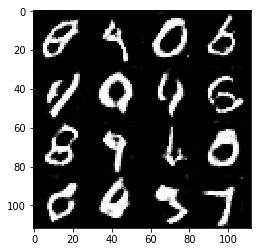

Epoch 2/2... Discriminator Loss: 1.0958... Generator Loss: 0.5996
Epoch 2/2... Discriminator Loss: 0.7933... Generator Loss: 1.9786
Epoch 2/2... Discriminator Loss: 1.1374... Generator Loss: 0.7517
Epoch 2/2... Discriminator Loss: 0.9695... Generator Loss: 1.3199
Epoch 2/2... Discriminator Loss: 1.1864... Generator Loss: 1.4823
Epoch 2/2... Discriminator Loss: 0.7058... Generator Loss: 1.7738
Epoch 2/2... Discriminator Loss: 0.6947... Generator Loss: 1.9857
Epoch 2/2... Discriminator Loss: 1.6355... Generator Loss: 0.7094
Epoch 2/2... Discriminator Loss: 0.9238... Generator Loss: 1.3529
Epoch 2/2... Discriminator Loss: 1.1529... Generator Loss: 0.7869


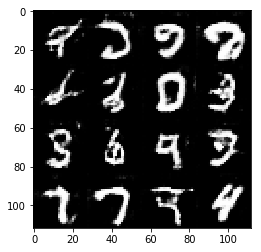

Epoch 2/2... Discriminator Loss: 0.8277... Generator Loss: 1.7098
Epoch 2/2... Discriminator Loss: 1.0075... Generator Loss: 0.6043
Epoch 2/2... Discriminator Loss: 1.0791... Generator Loss: 1.3475
Epoch 2/2... Discriminator Loss: 1.2493... Generator Loss: 1.7783
Epoch 2/2... Discriminator Loss: 0.8991... Generator Loss: 1.3859
Epoch 2/2... Discriminator Loss: 1.0980... Generator Loss: 1.7174
Epoch 2/2... Discriminator Loss: 1.2810... Generator Loss: 1.2265
Epoch 2/2... Discriminator Loss: 1.0008... Generator Loss: 0.9671
Epoch 2/2... Discriminator Loss: 1.0349... Generator Loss: 0.8262
Epoch 2/2... Discriminator Loss: 0.9771... Generator Loss: 1.3184


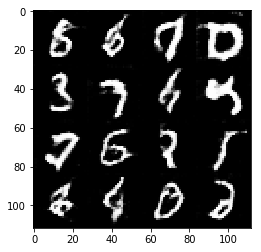

Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 1.9478
Epoch 2/2... Discriminator Loss: 1.0094... Generator Loss: 0.6809
Epoch 2/2... Discriminator Loss: 0.7627... Generator Loss: 1.4635
Epoch 2/2... Discriminator Loss: 0.8960... Generator Loss: 2.4481
Epoch 2/2... Discriminator Loss: 1.7679... Generator Loss: 0.4803
Epoch 2/2... Discriminator Loss: 1.3206... Generator Loss: 2.5791
Epoch 2/2... Discriminator Loss: 0.8767... Generator Loss: 1.8794
Epoch 2/2... Discriminator Loss: 0.7526... Generator Loss: 1.3595
Epoch 2/2... Discriminator Loss: 0.9982... Generator Loss: 1.5738
Epoch 2/2... Discriminator Loss: 2.0304... Generator Loss: 2.9652


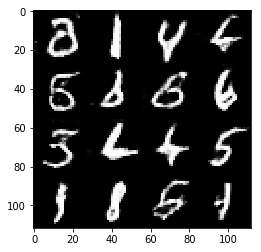

Epoch 2/2... Discriminator Loss: 1.1980... Generator Loss: 0.7685
Epoch 2/2... Discriminator Loss: 1.0403... Generator Loss: 2.9673
Epoch 2/2... Discriminator Loss: 1.2021... Generator Loss: 2.2150
Epoch 2/2... Discriminator Loss: 0.9396... Generator Loss: 2.2338
Epoch 2/2... Discriminator Loss: 0.9513... Generator Loss: 1.4718
Epoch 2/2... Discriminator Loss: 0.7673... Generator Loss: 1.6941
Epoch 2/2... Discriminator Loss: 0.7968... Generator Loss: 1.7983
Epoch 2/2... Discriminator Loss: 0.9380... Generator Loss: 2.8223
Epoch 2/2... Discriminator Loss: 1.0669... Generator Loss: 0.9535
Epoch 2/2... Discriminator Loss: 1.0276... Generator Loss: 1.4959


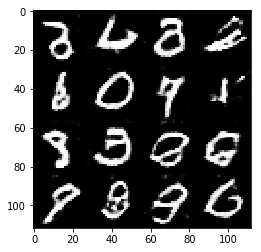

Epoch 2/2... Discriminator Loss: 1.9365... Generator Loss: 0.9947
Epoch 2/2... Discriminator Loss: 0.7148... Generator Loss: 1.7604
Epoch 2/2... Discriminator Loss: 0.9266... Generator Loss: 0.8499
Epoch 2/2... Discriminator Loss: 0.7702... Generator Loss: 1.4374
Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 1.5166
Epoch 2/2... Discriminator Loss: 1.1268... Generator Loss: 2.7709
Epoch 2/2... Discriminator Loss: 0.8388... Generator Loss: 1.6556
Epoch 2/2... Discriminator Loss: 1.3200... Generator Loss: 0.7080
Epoch 2/2... Discriminator Loss: 0.7788... Generator Loss: 1.1815
Epoch 2/2... Discriminator Loss: 0.7148... Generator Loss: 2.6907


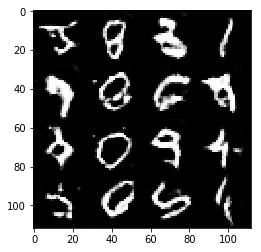

Epoch 2/2... Discriminator Loss: 1.3181... Generator Loss: 0.9722
Epoch 2/2... Discriminator Loss: 1.0674... Generator Loss: 1.7767
Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 2.5337
Epoch 2/2... Discriminator Loss: 0.6933... Generator Loss: 2.2521
Epoch 2/2... Discriminator Loss: 1.1011... Generator Loss: 1.4101
Epoch 2/2... Discriminator Loss: 0.6585... Generator Loss: 2.6908
Epoch 2/2... Discriminator Loss: 1.4260... Generator Loss: 0.5740
Epoch 2/2... Discriminator Loss: 1.1346... Generator Loss: 1.0918
Epoch 2/2... Discriminator Loss: 0.7392... Generator Loss: 1.9203
Epoch 2/2... Discriminator Loss: 1.1748... Generator Loss: 1.1416


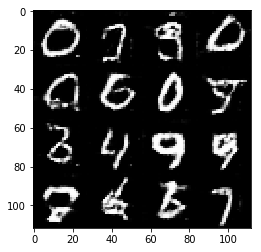

Epoch 2/2... Discriminator Loss: 0.9217... Generator Loss: 1.5251
Epoch 2/2... Discriminator Loss: 1.5983... Generator Loss: 0.5135
Epoch 2/2... Discriminator Loss: 1.0031... Generator Loss: 0.9867
Epoch 2/2... Discriminator Loss: 1.6994... Generator Loss: 0.8404
Epoch 2/2... Discriminator Loss: 1.0635... Generator Loss: 0.5272
Epoch 2/2... Discriminator Loss: 1.9947... Generator Loss: 3.1522
Epoch 2/2... Discriminator Loss: 0.6689... Generator Loss: 2.0491
Epoch 2/2... Discriminator Loss: 0.6432... Generator Loss: 3.1722
Epoch 2/2... Discriminator Loss: 0.6538... Generator Loss: 1.6588
Epoch 2/2... Discriminator Loss: 0.7502... Generator Loss: 1.9275


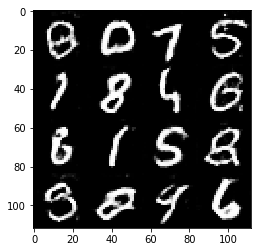

Epoch 2/2... Discriminator Loss: 0.8197... Generator Loss: 2.3074
Epoch 2/2... Discriminator Loss: 1.1616... Generator Loss: 1.0098
Epoch 2/2... Discriminator Loss: 1.0040... Generator Loss: 2.0238
Epoch 2/2... Discriminator Loss: 0.9332... Generator Loss: 2.6003
Epoch 2/2... Discriminator Loss: 1.0926... Generator Loss: 2.6004
Epoch 2/2... Discriminator Loss: 1.2482... Generator Loss: 1.3162
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 1.2175
Epoch 2/2... Discriminator Loss: 0.7081... Generator Loss: 2.0845
Epoch 2/2... Discriminator Loss: 0.6785... Generator Loss: 1.0455
Epoch 2/2... Discriminator Loss: 1.2146... Generator Loss: 0.9098


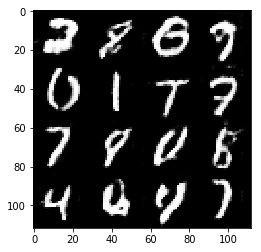

Epoch 2/2... Discriminator Loss: 0.8654... Generator Loss: 1.3236
Epoch 2/2... Discriminator Loss: 1.0168... Generator Loss: 1.9440
Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 1.7892
Epoch 2/2... Discriminator Loss: 1.1234... Generator Loss: 2.6934
Epoch 2/2... Discriminator Loss: 1.1035... Generator Loss: 3.4547


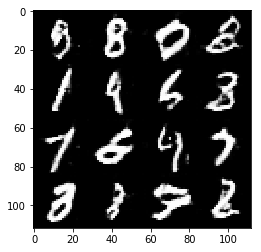

Done


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.4738... Generator Loss: 0.3323


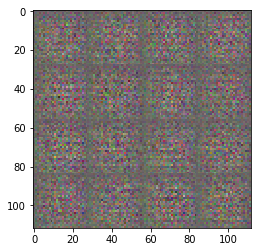

Epoch 1/1... Discriminator Loss: 0.7075... Generator Loss: 3.1988
Epoch 1/1... Discriminator Loss: 1.9010... Generator Loss: 10.1319
Epoch 1/1... Discriminator Loss: 1.7834... Generator Loss: 6.0956
Epoch 1/1... Discriminator Loss: 4.1914... Generator Loss: 0.3192
Epoch 1/1... Discriminator Loss: 2.5488... Generator Loss: 9.6652
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 7.7497
Epoch 1/1... Discriminator Loss: 2.7268... Generator Loss: 0.3610
Epoch 1/1... Discriminator Loss: 2.5078... Generator Loss: 0.2832
Epoch 1/1... Discriminator Loss: 0.4778... Generator Loss: 8.2021
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 1.3594


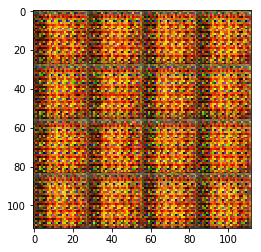

Epoch 1/1... Discriminator Loss: 0.6048... Generator Loss: 3.4872
Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.8378
Epoch 1/1... Discriminator Loss: 0.6549... Generator Loss: 2.9869
Epoch 1/1... Discriminator Loss: 0.6740... Generator Loss: 2.4839
Epoch 1/1... Discriminator Loss: 1.5468... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 0.6734... Generator Loss: 2.1419
Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 1.5241
Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 3.1293
Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 1.8996
Epoch 1/1... Discriminator Loss: 0.7677... Generator Loss: 1.8158


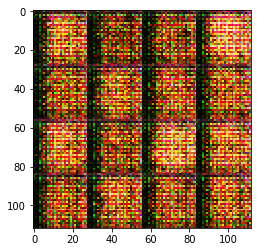

Epoch 1/1... Discriminator Loss: 1.7516... Generator Loss: 0.4819
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 0.6751... Generator Loss: 2.2224
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 1.7231
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 1.1871
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 1.3823
Epoch 1/1... Discriminator Loss: 0.8083... Generator Loss: 1.2518
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.6744
Epoch 1/1... Discriminator Loss: 0.6555... Generator Loss: 1.8591


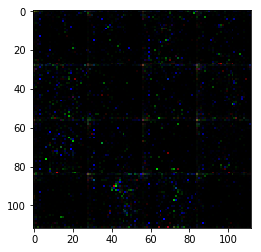

Epoch 1/1... Discriminator Loss: 0.6639... Generator Loss: 1.8196
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 0.6967... Generator Loss: 1.8463
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 0.7828... Generator Loss: 1.6835
Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 2.3625
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 1.3247
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 2.6128
Epoch 1/1... Discriminator Loss: 1.5329... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 2.5096... Generator Loss: 5.1159


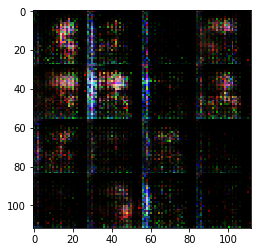

Epoch 1/1... Discriminator Loss: 1.6822... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.8640
Epoch 1/1... Discriminator Loss: 0.7422... Generator Loss: 2.0278
Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 3.1601
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 2.1729
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 3.0685
Epoch 1/1... Discriminator Loss: 0.6094... Generator Loss: 2.5059
Epoch 1/1... Discriminator Loss: 0.9419... Generator Loss: 2.0137
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 2.2891
Epoch 1/1... Discriminator Loss: 0.8071... Generator Loss: 2.5018


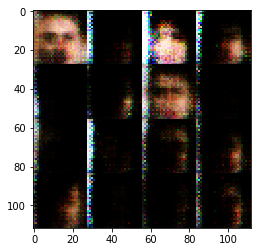

Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 2.9521
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 3.0622
Epoch 1/1... Discriminator Loss: 0.8261... Generator Loss: 1.8014
Epoch 1/1... Discriminator Loss: 1.6268... Generator Loss: 1.0977
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 2.4840
Epoch 1/1... Discriminator Loss: 1.5882... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.5208... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 0.9628


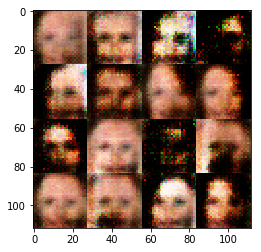

Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 1.5987
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.7594... Generator Loss: 0.3922
Epoch 1/1... Discriminator Loss: 1.7462... Generator Loss: 0.5196
Epoch 1/1... Discriminator Loss: 0.7283... Generator Loss: 1.6041
Epoch 1/1... Discriminator Loss: 0.8431... Generator Loss: 1.5089
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 1.8234... Generator Loss: 0.3937
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 1.1415


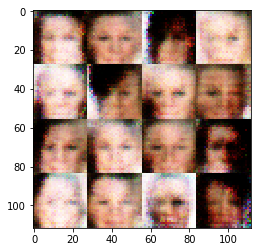

Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 0.8899... Generator Loss: 1.4554
Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 3.0079
Epoch 1/1... Discriminator Loss: 1.6486... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 2.8241
Epoch 1/1... Discriminator Loss: 0.6525... Generator Loss: 2.2383
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.3336
Epoch 1/1... Discriminator Loss: 0.7943... Generator Loss: 1.6749
Epoch 1/1... Discriminator Loss: 0.6893... Generator Loss: 2.3008
Epoch 1/1... Discriminator Loss: 1.6373... Generator Loss: 0.6506


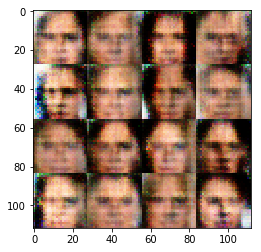

Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 1.3577
Epoch 1/1... Discriminator Loss: 0.8520... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 1.1581
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 1.2856
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 1.6349
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.9738
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 3.3082
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 2.2066
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 1.5558
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.6210


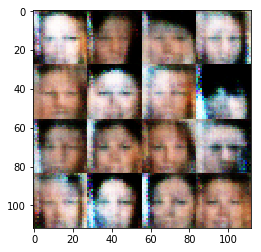

Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 2.1052
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 2.0194
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 1.1414
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 1.8772
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 1.8638
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 1.2155


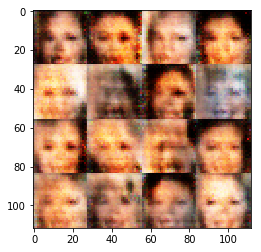

Epoch 1/1... Discriminator Loss: 1.9906... Generator Loss: 0.4583
Epoch 1/1... Discriminator Loss: 0.9533... Generator Loss: 1.5984
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 1.2402
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 1.8335
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 2.7331
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.5486
Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 1.6526
Epoch 1/1... Discriminator Loss: 1.9625... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 1.0276


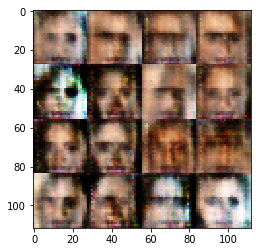

Epoch 1/1... Discriminator Loss: 0.8510... Generator Loss: 1.2904
Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 1.7771
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 1.4194
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 1.9884
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 1.5443
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.7149... Generator Loss: 2.5438
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 1.4286
Epoch 1/1... Discriminator Loss: 1.8172... Generator Loss: 0.4263


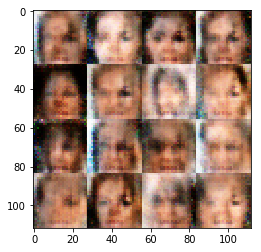

Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 1.7811
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.7654
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 1.0703


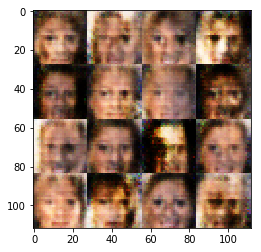

Epoch 1/1... Discriminator Loss: 0.7969... Generator Loss: 1.6543
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 1.6255
Epoch 1/1... Discriminator Loss: 1.5536... Generator Loss: 2.0086
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 1.2184
Epoch 1/1... Discriminator Loss: 0.8209... Generator Loss: 2.1072
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 1.3812


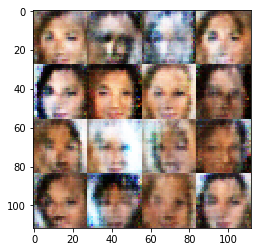

Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 1.4244
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 1.2533
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 1.4022
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 1.2079
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 1.5162
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 1.6634
Epoch 1/1... Discriminator Loss: 0.7678... Generator Loss: 1.8603
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 1.0074
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 1.3337


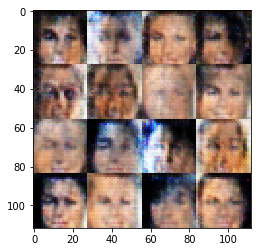

Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 1.4059
Epoch 1/1... Discriminator Loss: 1.5981... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 1.2589
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.9768
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 1.5381
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 1.7850
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 1.5412


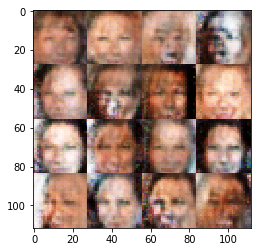

Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 1.6245
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 1.1267
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 1.1385
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 1.8764
Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 1.0816
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 1.0198


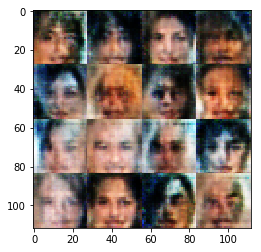

Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.1697
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.7122... Generator Loss: 0.4892
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 1.3938
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.5915... Generator Loss: 1.3179
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 1.3506


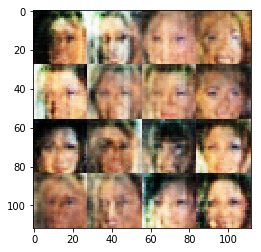

Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 1.0238
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 1.2712
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 1.5196
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 1.2753
Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.9427
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 1.6178
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 1.5543


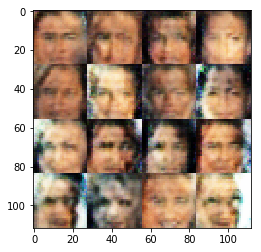

Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.3784
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 1.4625
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 1.1388
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 1.6328... Generator Loss: 0.4649
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 1.1600
Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 0.8424


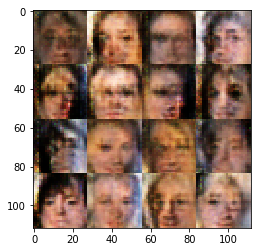

Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.5203... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 0.8536... Generator Loss: 1.2332


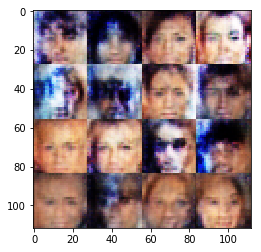

Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 1.6293
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 1.5519
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 1.2489


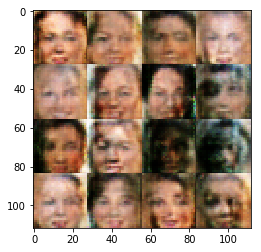

Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 1.1824
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 1.0864
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.9793
Epoch 1/1... Discriminator Loss: 1.5909... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 1.1111


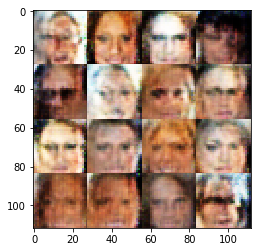

Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.6877... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 1.1607
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 1.1073
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 1.2495
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.4427
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.2925


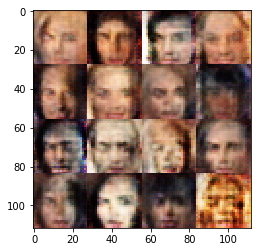

Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 1.3147
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.7334... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 1.1039
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 1.0021


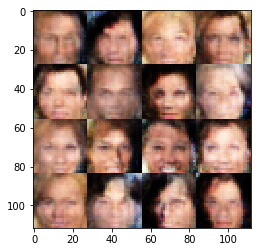

Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 1.5666
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 1.1573
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 1.3596
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 1.4501


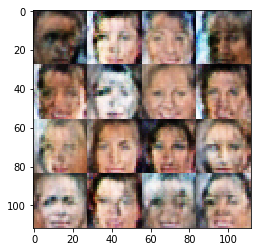

Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 1.2445
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.6838... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 1.1136
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.9098


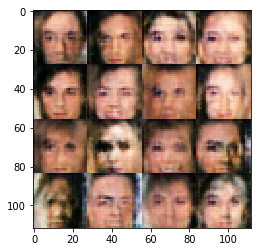

Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 1.2134
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 1.0605
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 1.3960
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 0.9260


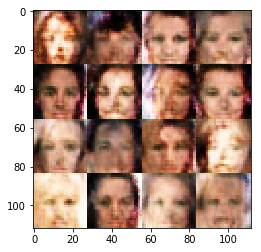

Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 1.0421
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 1.2672
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 1.1906
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 1.1878
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 1.0588
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 1.1717
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 1.6171


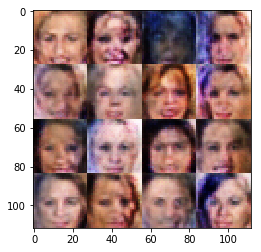

Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 1.1268
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.5462... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 1.3235
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 1.1930
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.9170


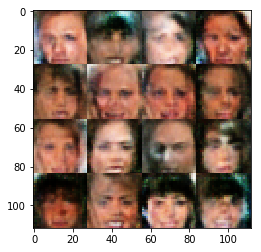

Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 1.1532
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 1.1264
Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 1.0687
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 1.2691
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7708


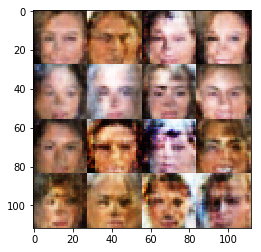

Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 1.1203


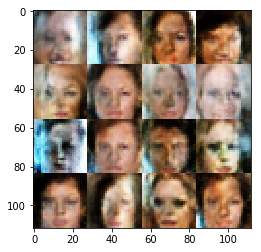

Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 1.0951
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.7284... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 1.2994
Epoch 1/1... Discriminator Loss: 1.6495... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 1.0968


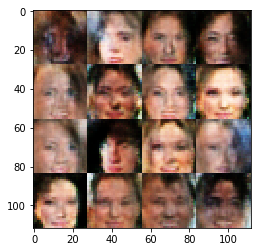

Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.5984... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.6270... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.5563... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.6230... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 0.5719


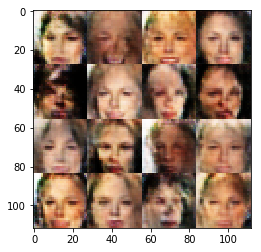

Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.8998
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 1.0541
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.8291


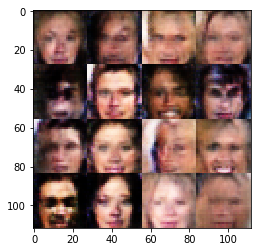

Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 1.2050
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 1.0028
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 1.0398
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.9745
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.9761


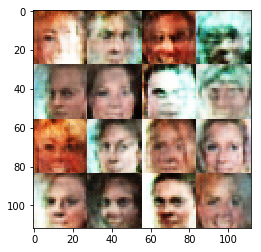

Epoch 1/1... Discriminator Loss: 1.6417... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.5356... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.5517... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.6157... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.9152


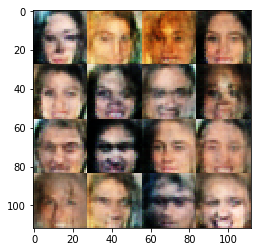

Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.5231
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 1.0834
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 1.0563
Epoch 1/1... Discriminator Loss: 1.8373... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.6431


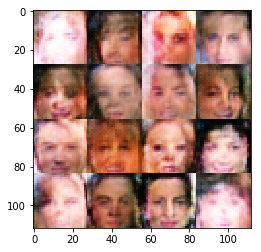

Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 1.0413
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 1.2956
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.8394... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 1.0452


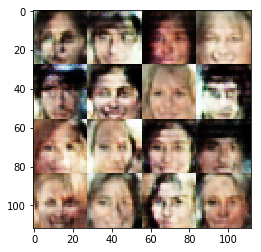

Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 1.0917
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 1.2828
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.6530... Generator Loss: 0.5358
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.9320


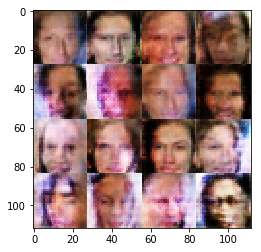

Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 1.2408
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 1.0860
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.9961
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.5779


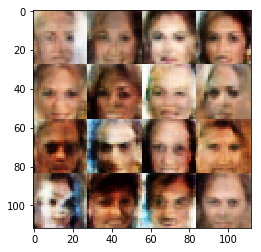

Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.6398... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 1.1769
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 1.1553
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.8024


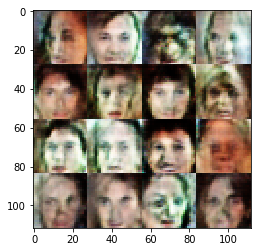

Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 1.2553
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.9775
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 1.1689
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 1.1653
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 1.0497


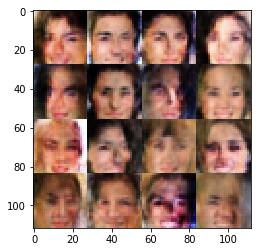

Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.5881... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.6200... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 1.2085
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7543


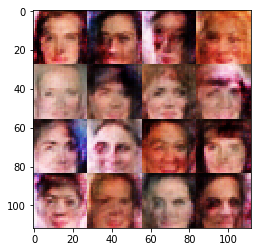

Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 1.1321
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 0.9779
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 1.3769
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 1.1871
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 1.0408


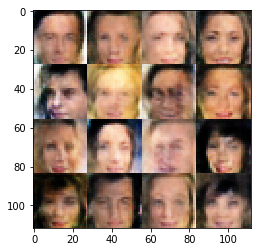

Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 1.1784
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 1.0357
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 1.5840
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 1.1354
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 1.0507
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.8452


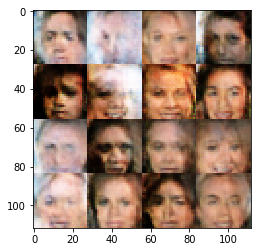

Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 1.1643
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.4893
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 1.1551
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.7084


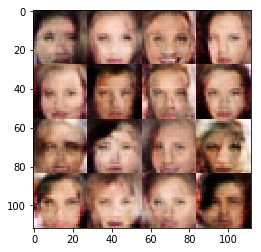

Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 1.6104... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 1.2044
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 1.2857
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.6443... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.6459... Generator Loss: 0.4552


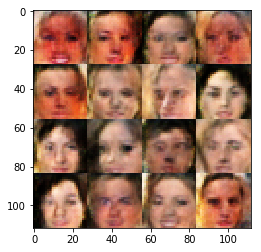

Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 1.0734
Epoch 1/1... Discriminator Loss: 1.7012... Generator Loss: 1.5282
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 1.5364
Epoch 1/1... Discriminator Loss: 1.7081... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.7464


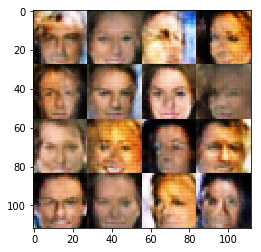

Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 1.3124
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.9269
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 1.7429... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 1.3903
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.1262


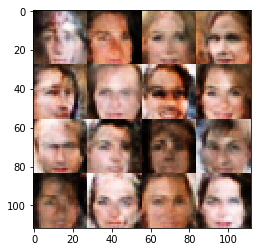

Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 1.0946
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 1.1239
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 1.1282
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 1.2512
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 1.0797


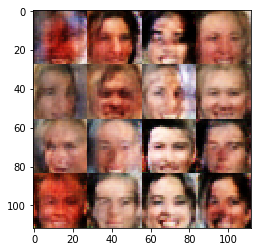

Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 1.0442
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 1.3160
Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 1.2266


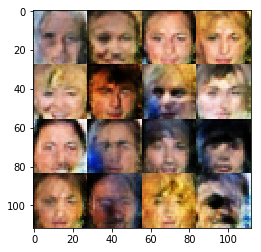

Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.8101... Generator Loss: 0.7475


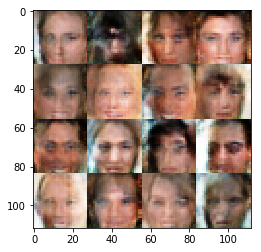

Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.4342
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 1.3287
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.9777


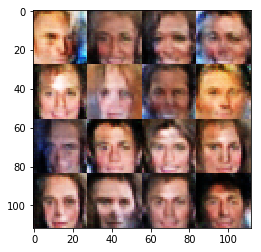

Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 1.0403
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.9546
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 1.0464


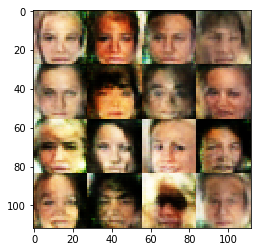

Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.7118... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 1.6084
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 1.5816
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 1.0667


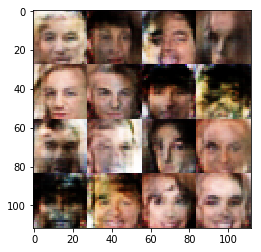

Epoch 1/1... Discriminator Loss: 1.5541... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 1.1700
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 1.5063
Epoch 1/1... Discriminator Loss: 1.5308... Generator Loss: 0.9983
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.7666


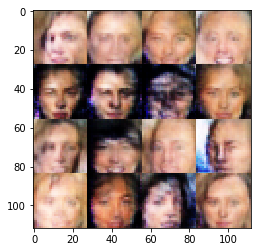

Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.5356... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 1.1435
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 1.0765
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 0.7869


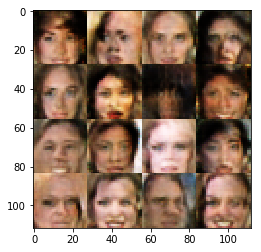

Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 1.1864
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.7423... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.5688... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.5651... Generator Loss: 0.9870


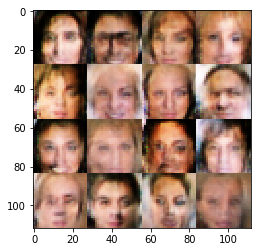

Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.7440... Generator Loss: 0.5360
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 1.2031
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.6370


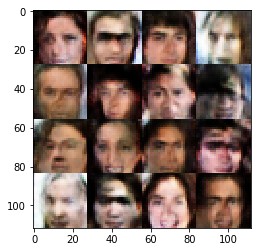

Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.5904... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.5751


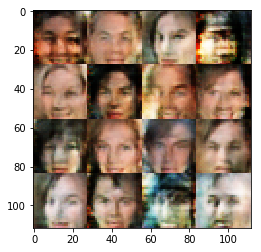

Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.2759
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 1.2618
Epoch 1/1... Discriminator Loss: 1.5802... Generator Loss: 0.4386
Epoch 1/1... Discriminator Loss: 2.2295... Generator Loss: 1.5380
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.8390


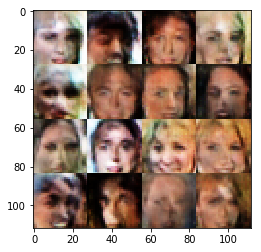

Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 1.5348
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 1.6289... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 1.2171


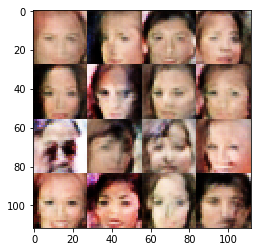

Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 1.1254
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 1.0501
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 2.0296
Epoch 1/1... Discriminator Loss: 1.6607... Generator Loss: 0.4771
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.6065


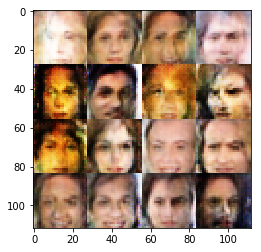

Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 2.0291
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 1.4393
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 1.1376
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6991


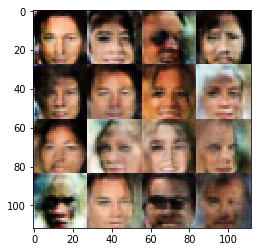

Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.6543... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 0.9522... Generator Loss: 1.6353
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 1.6111


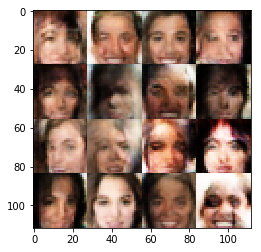

Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 1.4924
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 1.0840
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.6064... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.8470


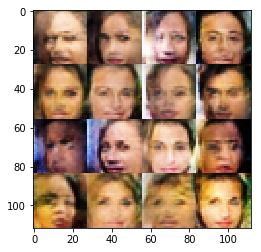

Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 1.2485
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.6603... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 1.8039... Generator Loss: 1.5627


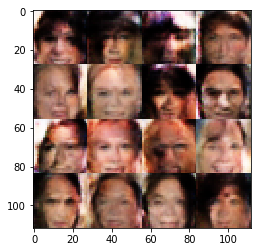

Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.3115
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 1.0853
Epoch 1/1... Discriminator Loss: 1.7242... Generator Loss: 0.4339
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 1.6509
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 1.5339
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.8060


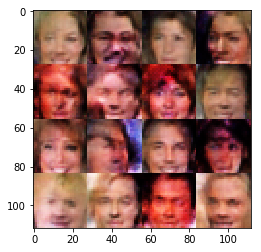

Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 1.0734
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 1.0201
Epoch 1/1... Discriminator Loss: 1.7584... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.6796... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.6613


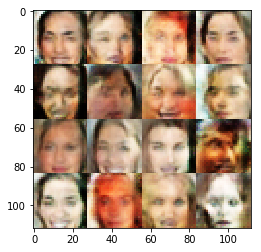

Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 0.8776... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 1.2123
Epoch 1/1... Discriminator Loss: 1.6838... Generator Loss: 0.3680
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 1.4137
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.2814


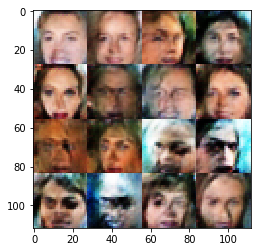

Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 1.5840
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 1.3458
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 1.1031
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 1.5754... Generator Loss: 0.8063


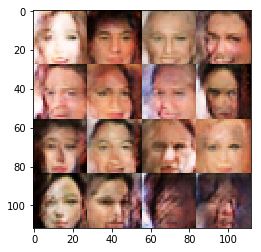

Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.1282
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.2132
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 1.2110
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.4943
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 1.2627


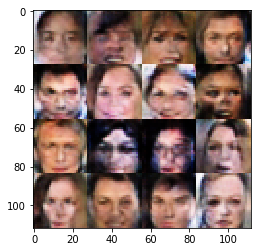

Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 1.1234
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 1.2994
Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 1.8141
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 2.1850... Generator Loss: 2.8160
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 1.1150


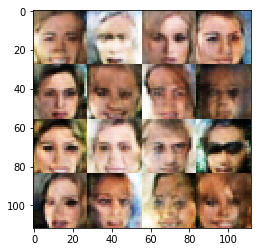

Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.9450
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 1.8217... Generator Loss: 0.3746
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 1.2039
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 1.2438
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.2441
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 1.2920
Epoch 1/1... Discriminator Loss: 1.6340... Generator Loss: 0.4216


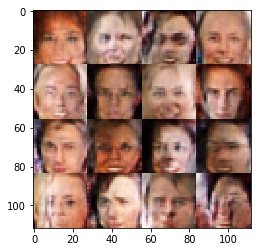

Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 1.3378
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 1.0149
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.5097
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 1.2638
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.1429
Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 2.0682
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.9294... Generator Loss: 1.2203


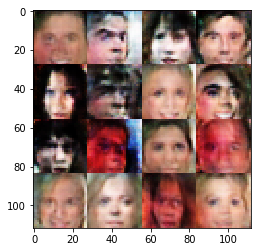

Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 1.9031
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 1.0761
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 1.0609
Epoch 1/1... Discriminator Loss: 0.8887... Generator Loss: 1.2635
Epoch 1/1... Discriminator Loss: 1.5672... Generator Loss: 0.4731


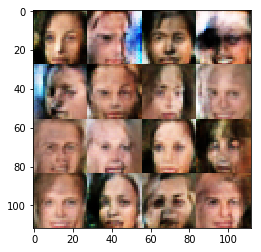

Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 1.1208
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 2.1472
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 0.8433... Generator Loss: 1.4658
Epoch 1/1... Discriminator Loss: 1.7981... Generator Loss: 3.3538
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 1.2826
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 1.0943
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 1.6275
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.4881


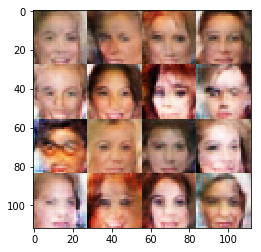

Epoch 1/1... Discriminator Loss: 0.6997... Generator Loss: 1.8641
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.6532... Generator Loss: 0.4871
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 1.1258
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 1.3492
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.6870... Generator Loss: 0.3978
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.9478


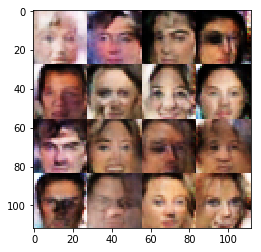

Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 2.0007
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.6820... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 2.1994... Generator Loss: 0.3201
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 1.1745
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 0.8392... Generator Loss: 1.1116


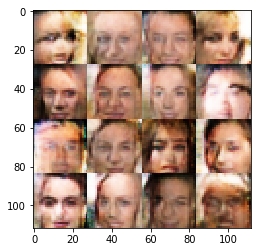

Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.8608... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 1.6798
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 1.0550
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 1.8267
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 1.2797
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 1.2077
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 2.0014... Generator Loss: 2.0172


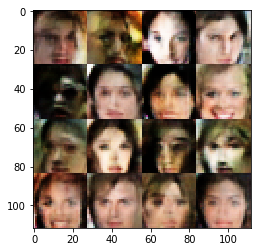

Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.2218
Epoch 1/1... Discriminator Loss: 0.5261... Generator Loss: 2.3582
Epoch 1/1... Discriminator Loss: 2.8052... Generator Loss: 3.3490
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 1.0872
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 1.1583
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 1.2294
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.7861


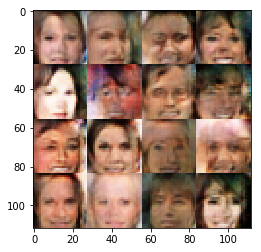

Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 1.2872
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 1.0605
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 1.4558
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.1047
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 1.2483


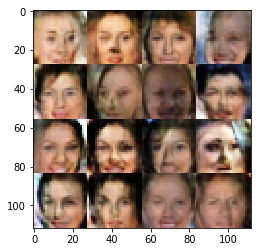

Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 1.2636
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 1.2113
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 1.0281
Epoch 1/1... Discriminator Loss: 0.7233... Generator Loss: 1.4752
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.8929


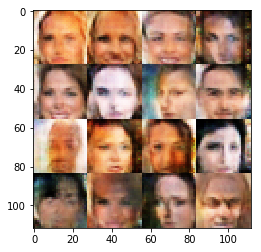

Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 1.3617
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 1.2925
Epoch 1/1... Discriminator Loss: 1.6789... Generator Loss: 2.3025
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 1.1214
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 0.6155... Generator Loss: 2.2832
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 2.0116... Generator Loss: 0.2343


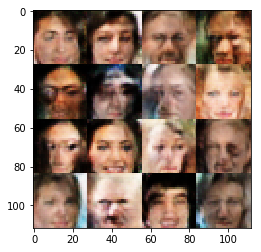

Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 1.1329
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.9423
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.2056
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 1.4971
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 1.2731
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.9509


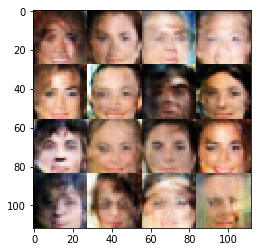

Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.0691
Epoch 1/1... Discriminator Loss: 1.6410... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 1.1325


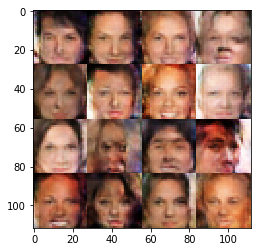

Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.6766... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 1.1435
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 1.1116
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 1.1247
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 1.7311
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 2.2390


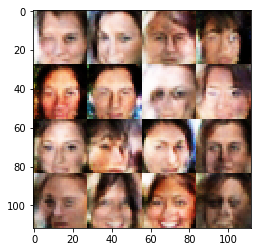

Epoch 1/1... Discriminator Loss: 1.6383... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 1.0379
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 1.0095
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 1.2110
Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 1.7998
Epoch 1/1... Discriminator Loss: 0.5798... Generator Loss: 1.5616


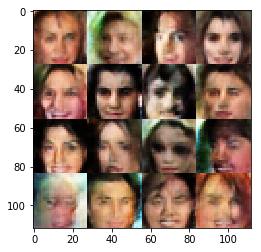

Epoch 1/1... Discriminator Loss: 0.6586... Generator Loss: 2.3672
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 2.1886
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 1.6849
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.7080... Generator Loss: 1.3395
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.2273
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.9828
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 1.8496


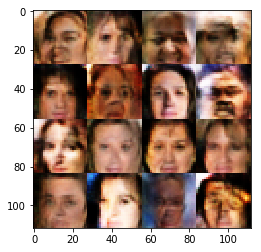

Epoch 1/1... Discriminator Loss: 0.8362... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 1.7141
Epoch 1/1... Discriminator Loss: 0.6827... Generator Loss: 2.1349
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 1.1918
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 2.0884
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 0.7878... Generator Loss: 1.4103


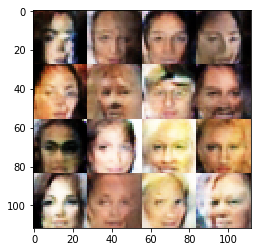

Epoch 1/1... Discriminator Loss: 0.8535... Generator Loss: 1.6760
Epoch 1/1... Discriminator Loss: 1.7938... Generator Loss: 0.2579
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.4803
Epoch 1/1... Discriminator Loss: 0.6914... Generator Loss: 1.8959
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 1.4062
Epoch 1/1... Discriminator Loss: 1.8580... Generator Loss: 3.4471
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 1.4395
Epoch 1/1... Discriminator Loss: 0.7873... Generator Loss: 1.9848


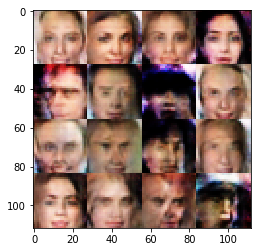

Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 1.0460
Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 2.0784
Epoch 1/1... Discriminator Loss: 0.6182... Generator Loss: 1.9566
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 1.1631
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 1.0023


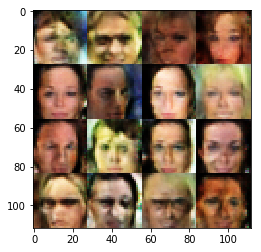

Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.6206... Generator Loss: 1.4442
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 1.8916
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 1.5694
Epoch 1/1... Discriminator Loss: 2.0583... Generator Loss: 1.2688
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 1.4815
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 1.0578


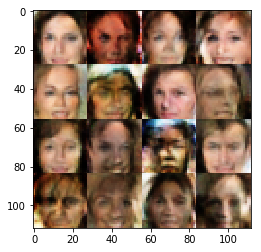

Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 1.1247
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 2.1488... Generator Loss: 2.4321
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 1.2586
Epoch 1/1... Discriminator Loss: 1.5726... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 0.8828... Generator Loss: 1.3229
Epoch 1/1... Discriminator Loss: 2.7027... Generator Loss: 3.3941


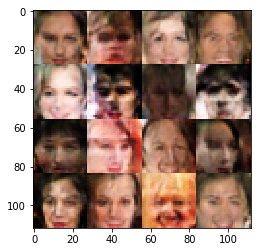

Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 1.0993
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 1.6468
Epoch 1/1... Discriminator Loss: 0.7857... Generator Loss: 3.2592
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.4898
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 1.8607
Epoch 1/1... Discriminator Loss: 0.5966... Generator Loss: 2.0890
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 0.8547... Generator Loss: 1.0508
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 0.7313... Generator Loss: 2.9506


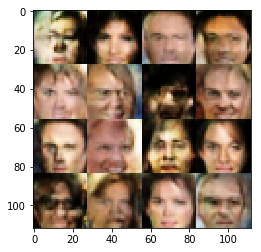

Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 1.0658
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.7669
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 2.1977
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 1.2133
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 1.6245
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 1.0226
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 1.0068
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 1.1330
Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 1.8766


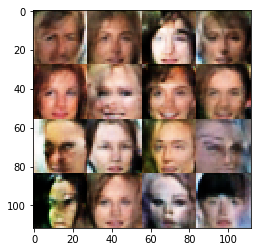

Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.5748
Epoch 1/1... Discriminator Loss: 0.8181... Generator Loss: 1.2197
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.5391
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 1.0807
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 1.3706
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 1.1865
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 1.6577
Epoch 1/1... Discriminator Loss: 0.6993... Generator Loss: 1.3688
Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 1.8850


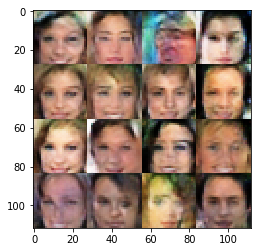

Epoch 1/1... Discriminator Loss: 0.5796... Generator Loss: 1.9588
Epoch 1/1... Discriminator Loss: 1.6492... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 1.5992
Epoch 1/1... Discriminator Loss: 0.7007... Generator Loss: 2.0306
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 3.3068
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 0.9139... Generator Loss: 2.7160
Epoch 1/1... Discriminator Loss: 0.6327... Generator Loss: 1.5780
Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 1.4087
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 1.3185


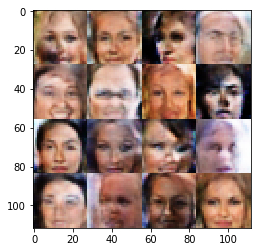

Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 1.2538
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 1.1537
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 2.5433
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 2.4495
Epoch 1/1... Discriminator Loss: 0.6877... Generator Loss: 1.6310
Epoch 1/1... Discriminator Loss: 0.7214... Generator Loss: 1.2809
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 3.9024
Epoch 1/1... Discriminator Loss: 2.4378... Generator Loss: 1.0320


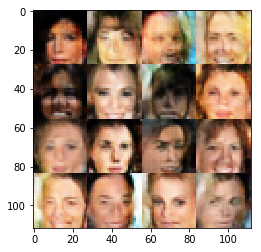

Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 1.1296
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 1.4785
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 1.6993
Epoch 1/1... Discriminator Loss: 0.9472... Generator Loss: 1.6124
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 2.4359


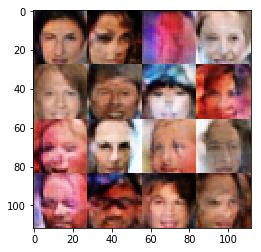

Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 1.6691
Epoch 1/1... Discriminator Loss: 0.7532... Generator Loss: 3.0166
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 0.6622... Generator Loss: 2.2123
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 4.5893
Epoch 1/1... Discriminator Loss: 0.7467... Generator Loss: 1.7424
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 2.0156
Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 1.2561
Epoch 1/1... Discriminator Loss: 0.7532... Generator Loss: 1.8117


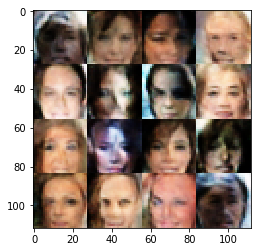

Epoch 1/1... Discriminator Loss: 0.7585... Generator Loss: 3.8736
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.6517... Generator Loss: 1.2649
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 2.0444
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 1.5175
Epoch 1/1... Discriminator Loss: 0.7457... Generator Loss: 1.7008
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 1.0359
Epoch 1/1... Discriminator Loss: 1.7381... Generator Loss: 0.4480
Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 2.3078
Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 0.9324


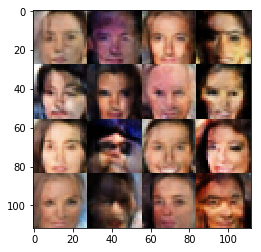

Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 1.2611
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 1.5874
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.1868
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 0.7595... Generator Loss: 1.6655
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 1.4350
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 1.6709


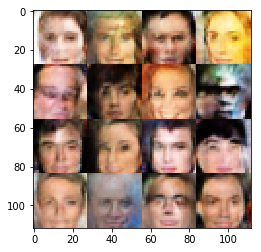

Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 1.6812
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.8286
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.8057
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 1.8576
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 1.3103
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 2.1689
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 1.5769


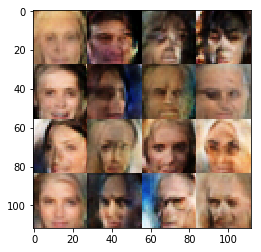

Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 1.0188
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 1.5795
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 1.0732
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 1.5159
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 1.4729
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 1.9245
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 1.0618
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 2.0202


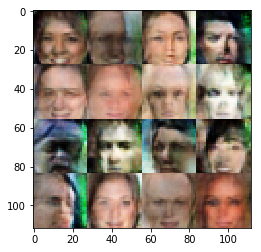

Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 1.3644
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.4541
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 1.8877
Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 1.5364
Epoch 1/1... Discriminator Loss: 0.7716... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 0.6530... Generator Loss: 2.1402
Epoch 1/1... Discriminator Loss: 0.7567... Generator Loss: 2.7240


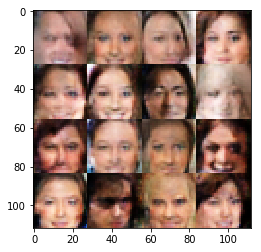

Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 1.6320
Epoch 1/1... Discriminator Loss: 2.5478... Generator Loss: 0.1814
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 0.9546
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 1.5640
Epoch 1/1... Discriminator Loss: 0.7088... Generator Loss: 1.9149
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 1.6368
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.5978


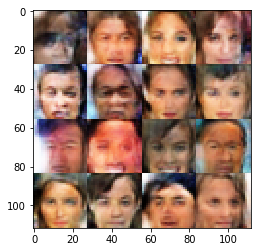

Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 1.0092
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 1.6556
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 1.2562
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 1.1363
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 1.1438
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 1.1333
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 1.3291
Epoch 1/1... Discriminator Loss: 0.7012... Generator Loss: 1.5961


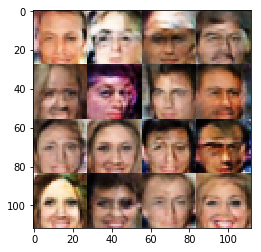

Epoch 1/1... Discriminator Loss: 1.6205... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 1.3888
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 1.0487
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 0.9392


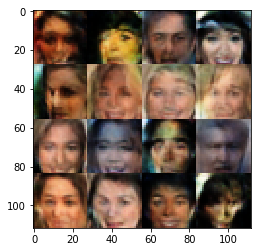

Epoch 1/1... Discriminator Loss: 1.5829... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 1.1717
Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 1.0709


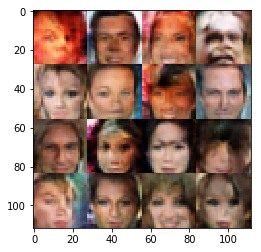

Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 1.3775
Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 1.3068
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 1.0693
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 1.1157
Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 2.0692
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 1.2855
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.0871
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 0.9505


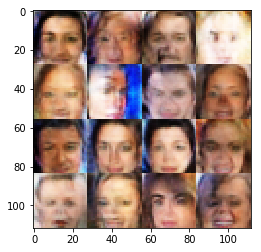

Epoch 1/1... Discriminator Loss: 0.7905... Generator Loss: 1.6201
Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 2.2579... Generator Loss: 3.9343
Epoch 1/1... Discriminator Loss: 0.6181... Generator Loss: 2.1036
Epoch 1/1... Discriminator Loss: 0.8552... Generator Loss: 1.8445
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.4956
Epoch 1/1... Discriminator Loss: 1.7895... Generator Loss: 2.1630
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 1.3272
Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 1.1601
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.0159


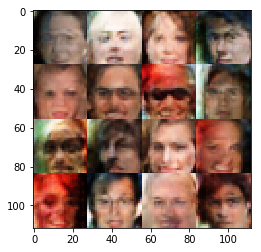

Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 0.8874... Generator Loss: 1.4104
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 1.2163
Epoch 1/1... Discriminator Loss: 1.6683... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 1.7511
Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 1.9130
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 1.1289
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 1.1111


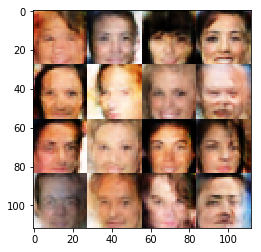

Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 1.5328
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 1.8053
Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 2.1909
Epoch 1/1... Discriminator Loss: 1.5996... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 0.6949... Generator Loss: 1.8551
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.5210
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 1.7141
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 1.5535
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.4449
Epoch 1/1... Discriminator Loss: 0.5728... Generator Loss: 1.7516


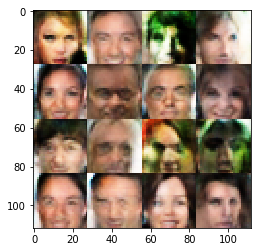

Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.9522
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 1.5165
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 1.5378
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 1.7816
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 1.5300
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.1905
Epoch 1/1... Discriminator Loss: 0.6901... Generator Loss: 1.6544


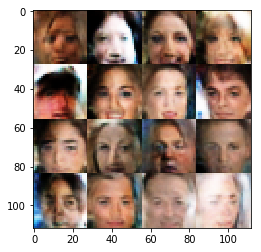

Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 0.5694... Generator Loss: 2.7656
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 0.6729... Generator Loss: 1.1864
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 3.3060
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 1.7677
Epoch 1/1... Discriminator Loss: 0.6872... Generator Loss: 2.7398
Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 1.3764
Epoch 1/1... Discriminator Loss: 0.9410... Generator Loss: 2.6403
Epoch 1/1... Discriminator Loss: 0.7998... Generator Loss: 1.3524


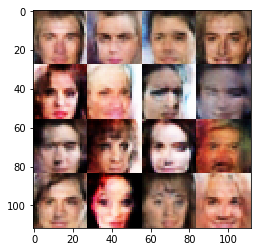

Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 2.7972
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 2.4184
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 1.3495
Epoch 1/1... Discriminator Loss: 0.9373... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 1.6927
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 2.0360
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 1.5349
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 1.3477
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 1.0208


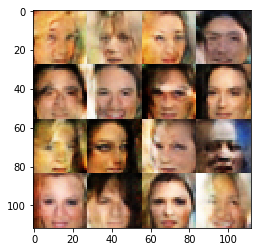

Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 1.5963
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 1.0184
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.2548
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 1.7248
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 1.3490
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 1.9058
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.8315


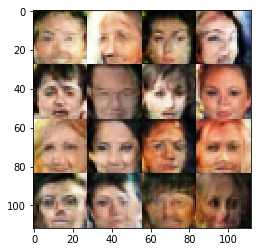

Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 1.6673
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 1.5410
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 1.3488
Epoch 1/1... Discriminator Loss: 2.1482... Generator Loss: 0.2122
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 0.5724... Generator Loss: 2.5184
Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 2.8738
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 1.1087


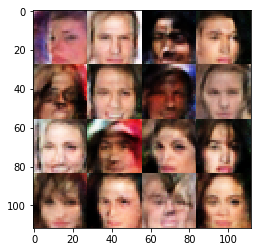

Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 1.6362
Epoch 1/1... Discriminator Loss: 0.9522... Generator Loss: 1.7501
Epoch 1/1... Discriminator Loss: 0.5387... Generator Loss: 2.3810
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 1.7339
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 1.4426
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 1.2838
Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 1.5409
Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 1.7478
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 1.7290


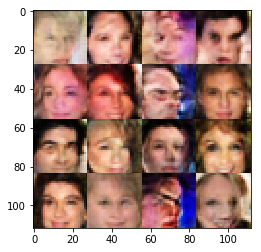

Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 2.3058
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 1.1233
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 1.4162
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 1.8758... Generator Loss: 1.9126
Epoch 1/1... Discriminator Loss: 1.8291... Generator Loss: 0.4980
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 2.2182
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 0.6249... Generator Loss: 1.5943
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.1577


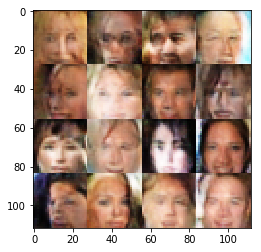

Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 1.5795
Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 1.3936
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 2.8553
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 1.3790
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 1.1437
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 1.1718
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 1.3620
Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 1.5307
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 1.7946


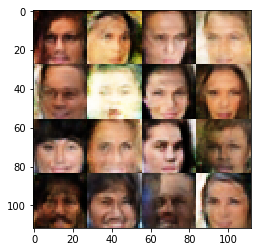

Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 1.4958
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 1.0147
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 1.3077
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.7511


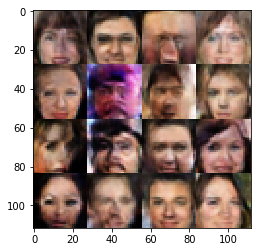

Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 2.0898
Epoch 1/1... Discriminator Loss: 0.7861... Generator Loss: 1.5346
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.4975
Epoch 1/1... Discriminator Loss: 0.7544... Generator Loss: 1.8737
Epoch 1/1... Discriminator Loss: 2.8975... Generator Loss: 3.1678
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.5663
Epoch 1/1... Discriminator Loss: 0.6513... Generator Loss: 1.7437
Epoch 1/1... Discriminator Loss: 0.6124... Generator Loss: 1.8088
Epoch 1/1... Discriminator Loss: 1.6587... Generator Loss: 2.5267
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 1.1417


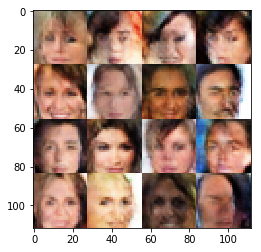

Epoch 1/1... Discriminator Loss: 0.6797... Generator Loss: 1.9397
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.5188
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 2.4588
Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 1.4950
Epoch 1/1... Discriminator Loss: 0.5133... Generator Loss: 2.5958
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.1713
Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 3.1309
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.5942
Epoch 1/1... Discriminator Loss: 0.8476... Generator Loss: 2.1038


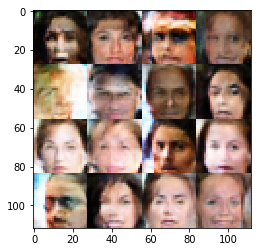

Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 1.3584
Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 2.3350
Epoch 1/1... Discriminator Loss: 0.5923... Generator Loss: 2.6830
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 1.1177
Done


In [14]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.